In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
import joblib

In [16]:
train_df = pd.read_parquet("data/spaceship-titanic-train.parquet")
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Cabin_deck,Cabin_num,Cabin_side
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0.0,P
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0.0,S
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0.0,S
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,0.0,S
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,1.0,S


In [17]:
X = train_df.drop("Transported", axis=1)
y = train_df["Transported"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y)

In [18]:
model = XGBClassifier(
    eval_metric="logloss",
    tree_method="hist",
    enable_categorical=True
)

model.fit(X_train, y_train)

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:PassengerId: object, HomePlanet: category, Destination: category, Cabin_deck: category, Cabin_side: category

In [5]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8027602070155262
              precision    recall  f1-score   support

       False       0.79      0.83      0.81       863
        True       0.82      0.78      0.80       876

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739



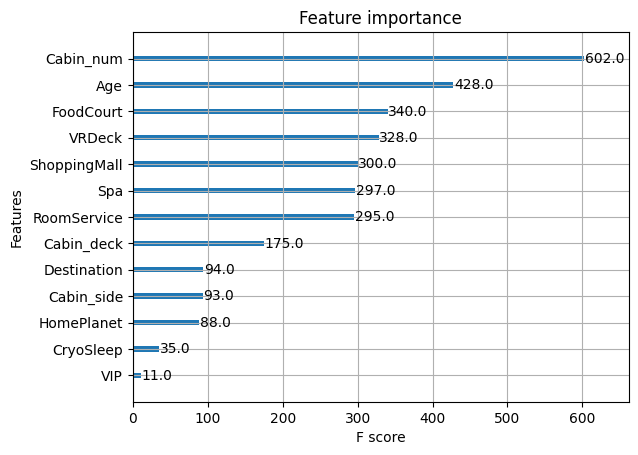

In [6]:
plot_importance(model)
plt.show()

In [7]:
params = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 300],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid = GridSearchCV(
    XGBClassifier(tree_method="hist", enable_categorical=True, eval_metric="logloss"),
    param_grid=params,
    scoring="accuracy",
    cv=3,
    verbose=1
)
grid.fit(X_train, y_train)
print("Best Params:", grid.best_params_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best Params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}


In [8]:
best_model = grid.best_estimator_
joblib.dump(best_model, "../../models/XGB-spaceship-titanic.pkl")

['../../models/XGB-spaceship-titanic.pkl']

In [9]:
model = joblib.load("../../models/XGB-spaceship-titanic.pkl")

In [12]:
test_df = pd.read_parquet("data/spaceship-titanic-test.parquet")
test_df.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_deck,Cabin_num,Cabin_side
0,0013_01,Earth,True,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,G,3.0,S
1,0018_01,Earth,False,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,F,4.0,S
2,0019_01,Europa,True,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,C,0.0,S
3,0021_01,Europa,False,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,C,1.0,S
4,0023_01,Earth,False,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,F,5.0,S


In [14]:
passenger_ids = test_df["PassengerId"]
X_test_final = test_df.drop("PassengerId", axis=1)
y_test_pred = model.predict(X_test_final)

submission_df = pd.DataFrame({
    "PassengerId": passenger_ids,
    "Transported": y_test_pred.astype(bool)
})

submission_df.to_csv("data/submission.csv", index=False)

submission_df.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
